In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px



In [3]:
ROOT = Path.cwd()
DATA_PATH = ROOT/'data'/'raw'/'housing.csv'

df = pd.read_csv(DATA_PATH)

In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  str    
dtypes: float64(9), str(1)
memory usage: 1.6 MB


In [5]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


In [7]:
null_values = df.isnull().sum()
null_pct = null_values / len(df) *100

null_df = pd.concat([null_values,null_pct], axis=1)
null_df.columns = ['count','percentage']
print(null_df)

                    count  percentage
longitude               0    0.000000
latitude                0    0.000000
housing_median_age      0    0.000000
total_rooms             0    0.000000
total_bedrooms        207    1.002907
population              0    0.000000
households              0    0.000000
median_income           0    0.000000
median_house_value      0    0.000000
ocean_proximity         0    0.000000


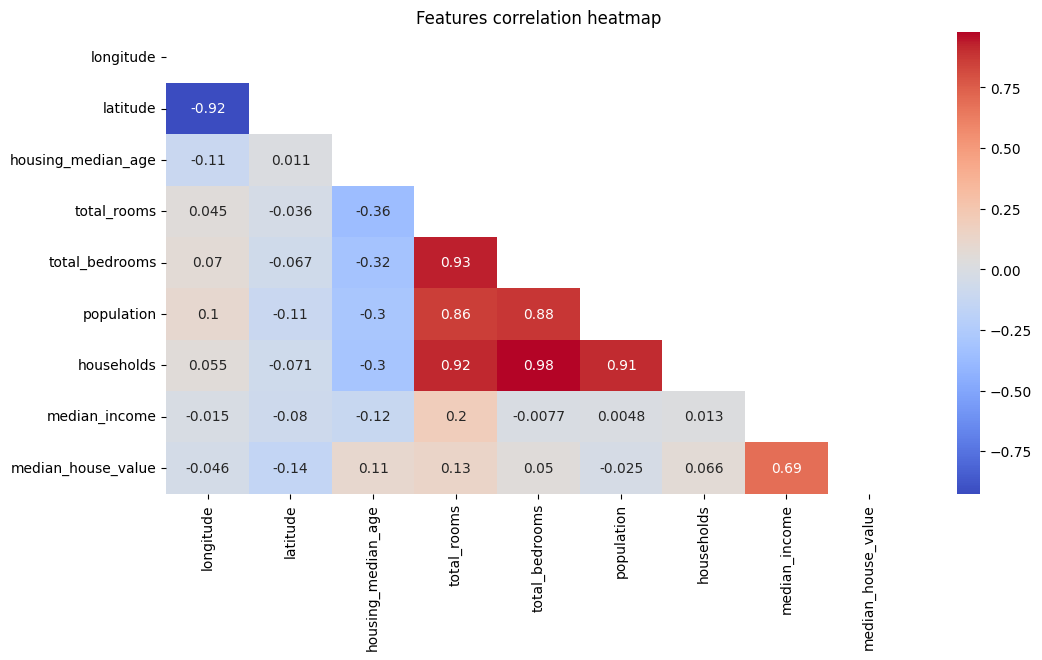

In [8]:
corr_matrix = df.select_dtypes(include=[np.number]).corr()

mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12,6))

sns.heatmap(corr_matrix, mask=mask_upper, annot=True, cmap='coolwarm')
plt.title('Features correlation heatmap')

plt.show()



## Target distribution analysis:

we look at the distribution of the target: `median_house_value`

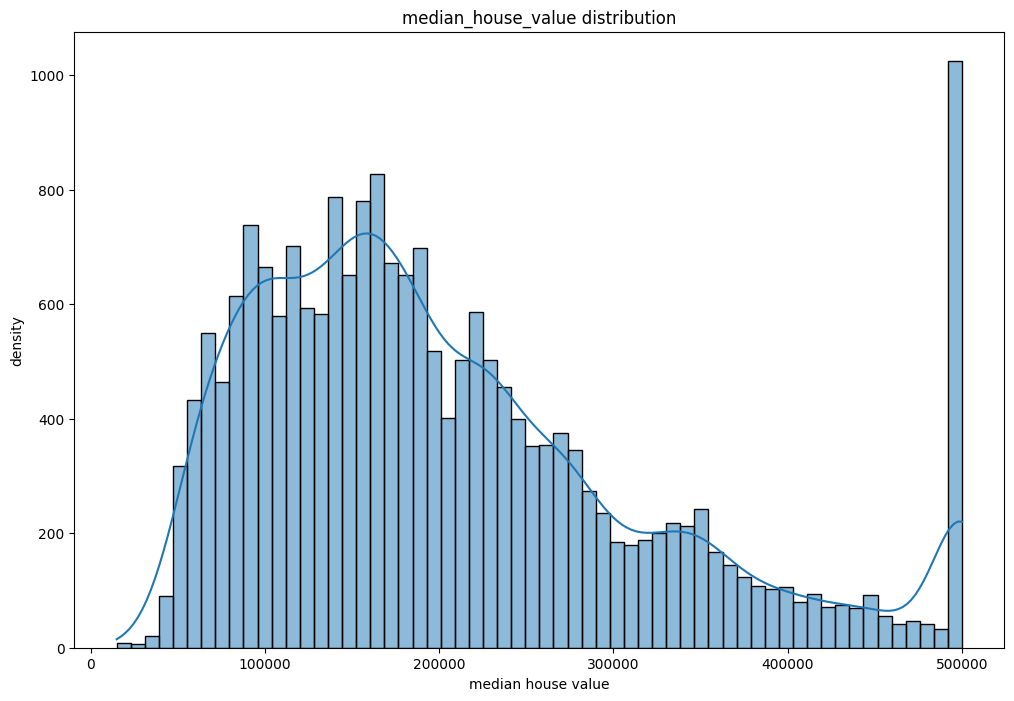

In [9]:
target = df['median_house_value']

plt.figure(figsize=(12,8))

sns.histplot(target, kde=True, bins= 60)
plt.title('median_house_value distribution')
plt.xlabel('median house value')
plt.ylabel('density')

plt.show()

from the distribution we can clearly notice a right-skewed distribution **with a pick aound 500000** I will conduct further analysis to state the motivation of the pick.

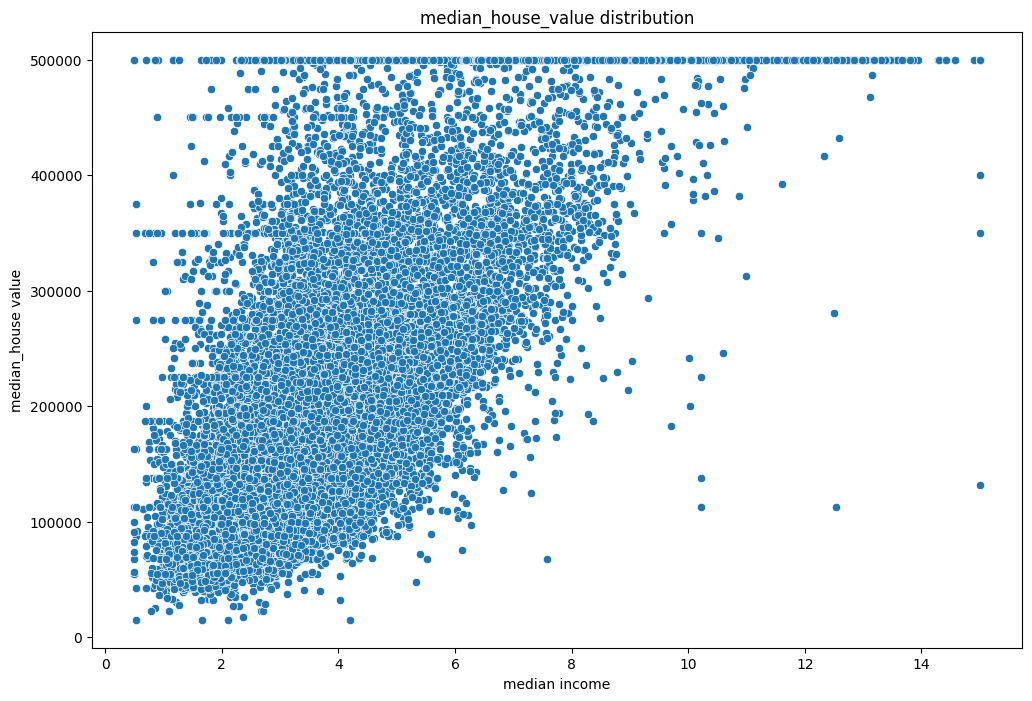

In [10]:
plt.figure(figsize=(12,8))

sns.scatterplot(data=df, x='median_income', y= 'median_house_value')
plt.title('median_house_value distribution')
plt.xlabel('median income')
plt.ylabel('median_house value')

plt.show()

In [11]:

p95 = lambda x: x.quantile(0.95)

p96 = lambda x: x.quantile(0.96)

print(p95(target))
print(p96(target))

489809.9999999999
500001.0


the data above the p95 are censored (i.e house values over p95 are set to 501000) so we will drop those datapoints since we cannot assert the real value of the house the model would be unable to make prediction.

we drop values where median_house_value > 501000

## Extremly large values on other features

I will look at the features `total_rooms`, `population`, `households`, since I notice some weird max values

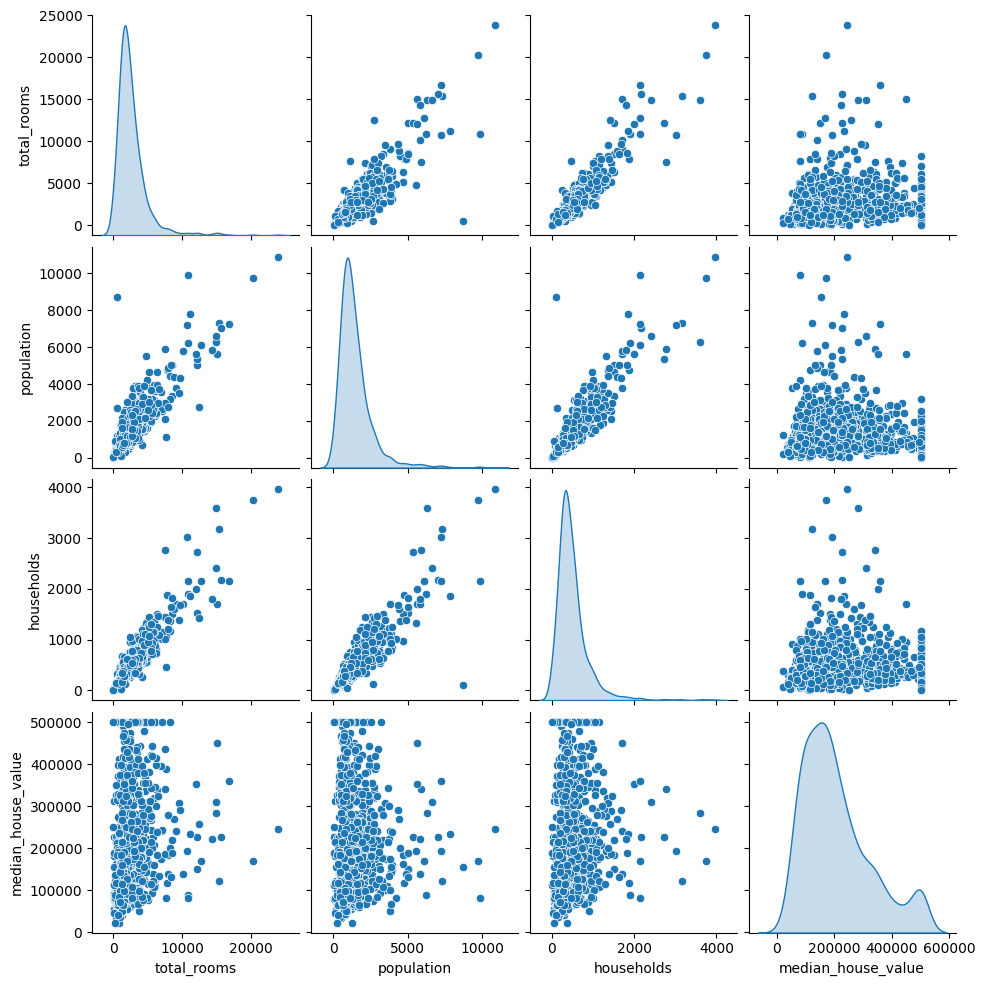

In [12]:

cols = ['total_rooms', 'population', 'households', 'median_house_value']


sns.pairplot(df[cols].sample(1000), diag_kind='kde')
plt.show()

In [13]:
rooms_per_households = (df['total_rooms'] / df['households']).mean()
bedrooms_per_households = (df['total_bedrooms']/df['households']).mean()
print(rooms_per_households)
print(bedrooms_per_households)

5.428999742190376
1.0970623858069952


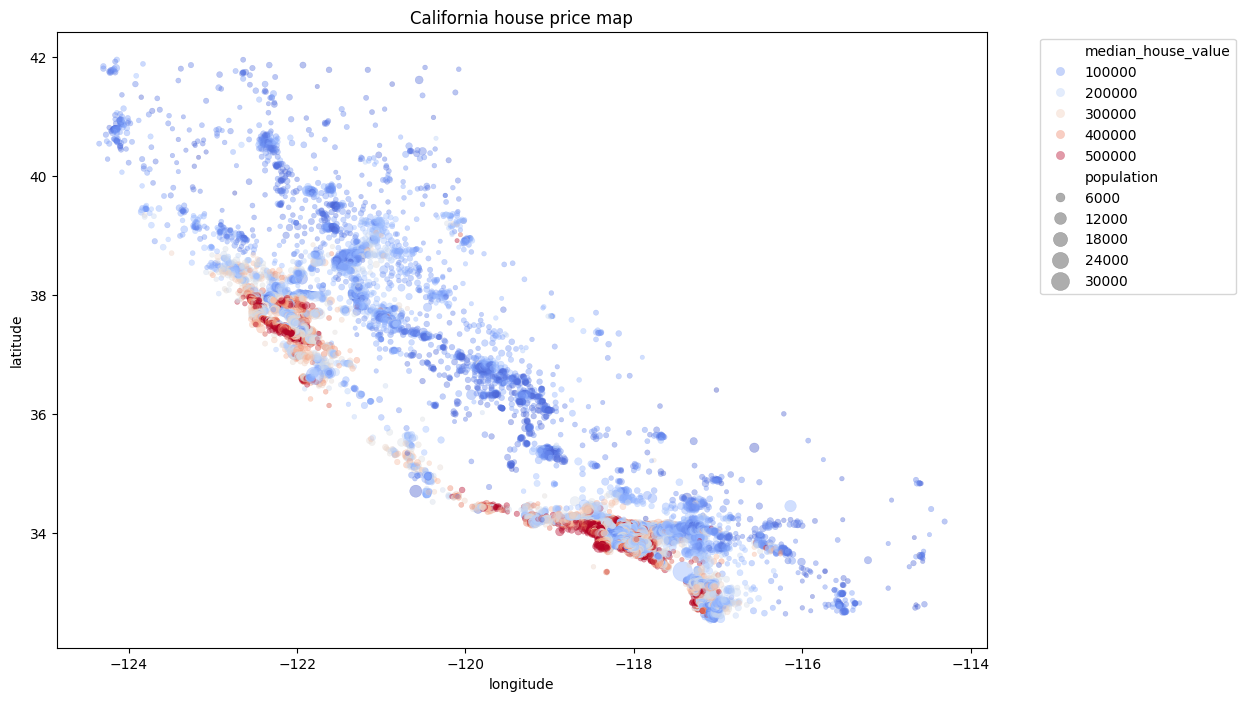

In [14]:
plt.figure(figsize=(12,8))

sns.scatterplot(
    data=df, 
    x='longitude', 
    y='latitude', 
    hue='median_house_value', 
    size='population', 
    palette='coolwarm', 
    alpha=0.4, 
    sizes=(10, 200),
    edgecolor=None
)

plt.title('California house price map')
plt.xlabel('longitude')
plt.ylabel('latitude')


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 

plt.show()

In [15]:


fig = px.scatter_mapbox(
    df, 
    lat="latitude", 
    lon="longitude",    
    color="median_house_value", 
    size="population",          
    color_continuous_scale=px.colors.sequential.Jet, 
    size_max=15,                
    zoom=5,                     
    mapbox_style="open-street-map", 
    title="California Housing Map"
)

fig.show()


C:\Users\morio\AppData\Local\Temp\ipykernel_11232\3120105771.py:1: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig = px.scatter_mapbox(


from the map can observe tha the **position** of the house is a strong indicator of the **value**